## GUIDE PRATIQUE DE L'OUTIL "OPTIMIZATION"

L'objectif de ce guide est d'illustrer le fonctionnement de la class 'optimization' avec des exemples clef-en-mains.

L'outils 'optimization' fournit un moyen d'optimisation sur des structures multi-couches de manière user-friendly et sans connaissance préliminaire sur le sujet de l'optimisation globale.

Cette classe Python contient également des fonctionnalités plus avancées (choix de l'algorithme, test de robustesse, clustering) ...

# (1/5) Fonctionnalité de base

Pour illustrer les résults basiques du code, nous allons prendre un exemple de référence : le Mirroir de Bragg (https://fr.wikipedia.org/wiki/Miroir_de_Bragg).

``` Objectif physique ``` : trouver la structure multi-couche qui maximise la réflectance $R$ pour une longueur d'onde donnée $\lambda$.

``` Paramètres à optimiser ``` : les épaisseurs des couches

``` Grandeur maximisée ``` : la réflectance

**Etape 1 : appeler la bibliothèque "optimization"**

In [1]:
import numpy as np
import PyMoosh as pm
from PyMoosh.optimization import optimization

/home/stagiaire1/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


ModuleNotFoundError: No module named 'PyMoosh.optimization'

**Etape 2 : Définir la structure à optimiser**

Forme de la structure : une alternance de $n$ couches d'indice optique $n_1$  et $n_2$ commençant et se terminant par l'indice fort $n_2$.

In [3]:
# nombre de couche
n = 30

# création de la structure
# la procédure est la même que pour la création d'une structure PyMoosh
mat = [1.0, 1.5**2, 2.0**2]
stack =  [0] + [2, 1] * n + [2, 0]
thickness = [100.0 for _ in stack]

Remarque : les épaisseurs des couches, notées $thickness$, sont données ici seulement pour l'initialisatio de l'optimisation.

**Etape 3 : Définir les limites de l'optimisation.**

Il faut borner les épaisseurs des couches. Le code suivant propose des limites identiques pour chaque couches, bien qu'il soit possible de les borner individuellement.

In [4]:
min_th, max_th = 0.0, 150.0 # nm
X_min = min_th * np.ones_like(stack)
X_max = max_th * np.ones_like(stack)

Ici, la variable `X_min` est une liste même longueur que la taille de $stack$, et contient les valeurs inférieurs autorisées pour chacune des épaisseurs.
Ainsi, la première couche (indice 0) a une épaisseur minimale de `X_min[0]`, la seconde a une épaisseur minimale `X_min[1]`, et ainsi de suite. De manière analogue, `X_max` encapsule les bornes supérieurs de chacune des couches.

Attention : `X_min` et `X_max` doivent être des numpy arrays !

**Etape 4 : Sous quelle lumière la structure est éclairée ?**

- La variable `wl_domain` indique dans quelle plage de longueur d'onde l'**AFFICHAGE** de la réflectance sera faite.

- La variable `computation_window` indique dans quelle plage de longueur d'onde les **CALCULS** de la réflectance sont faits.

- La variable `incidence` contient l'angle d'incidence (**radian**) d'une onde plane par rapport à la surface.

- La variable `polar` est la polarisation de cette onde : 0 correspond à TE, 1 à TM.

Attention : il ne faut pas confondre `wl_domain` et `computation_window`! En effet, plus ce dernier contient de longueur d'onde, plus les calculs peuvent durer longtemps.

In [5]:
# Light parameters:
wl_domain = np.linspace(400, 600, 400) # Has to be an array !
incidence = 0.0
polar = 0

# we only want the structure to reflect maximaly this wavelength.
# We don't care about the other wavelengths, so we don't constrain the other wavelengths.

computation_window = np.array(600.0) # Has to be an array !

**Etape 5 : Définir la grandeur physique à maximiser**

La grandeur physique a optimisée est découpée en deux parties:
- sa forme en fonction de la longueur d'onde $\lambda$,
- sa nature propre.

Par défaut, des grandeurs physiques de références sont implémentées dans la classe `optimization`, comme la réflectance, la transmittance, l'absorption, le courant de court-circuit et le courant de court-circuit théorique. Des mot-clefs sont associés à chacune de ces propriétés, respectivement : R, T, A, C et CM. 

De plus, la forme par défaut de la grandeur physique est une constante égale à 1.0 indépendante de $\lambda$.

Dans notre cas, nous voulons maximiser la réflectance, c'est à dire la placer à 1.0. Ainsi, nous devons simplement utiliser le mot-clef 'R' pour maximiser à 1.0 la reflectance.


In [6]:
grandeur = ['R']

Note : il est possible de renseigner plusieurs grandeurs physique dans cette variable. Ainsi, la première sera la grandeur utilisée pour les calculs de l'optimisation. Les suivantes ne seront que présentes pour l'affichage et non les calculs.

**Etape 6 : Budget et nombre de runs**

Deux paramètres techniques mais cruciaux sont à définir maintenant.
L'algorithme utilisé pour effectuer l'optimisation fait des calculs pour trouver la meilleur solution.
Plus précisément, il compare des solutions possibles et créer un nouvel individu (analogue de l'évolution des êtres vivants) s'il remplit les critères de sélection.
Cependant, la création d'un nouvel individu a un coût en temps et en mémoire qu'il faut borner.
Ici, le nombre de création de nouvel individu est borné : c'est le `budget` de l'optimisation.
Il est également possible d'executer plusieurs fois l'algorithme puis de comparer les résults. Le `nombre de runs` est le nombre de fois que l'algorithme d'optimisation est executé. Pour gagner du temps, plusieurs runs sont faites sur des coeurs différents.

In [7]:
# Plus le budget est grand, plus la simulation dure longtemps, et plus l'algorithme donne un bon résultat.
budget = 10000

# Nous nous limiterons à une seule run.
nb_runs = 1

**Etape 7 : Optimisation !**

Il suffit d'utiliser ces deux lignes de codes pour optimiser notre problème.

Au cours de l'optimisation, la progression de l'optimisation est affichée, ainsi que le coût (current cost) actuel.
Quand la progression atteint 100%, l'algorithm **global** a atteint le budget.
Plus le coût est proche de zéro, plus la meilleur solution actuelle est proche de l'objectif désiré.
Dans le cas ou la grandeur physique est la réflectance, la transmittance ou l'absorbance, le coût est égal à $1 - R$.

Plusieurs informations sont affichées une fois l'optimisation terminée :
- la courbe de convergence
- le coût de la meilleure solution trouvée
- les épaisseurs de la structure trouvée
- la réflectance de la structure sur la plage d'affichage `wl_domain`
- Une illustration des couches de la structure.

Current Time = 15:07:27
Progression : 3.34%. Current cost : 4e-05
Progression : 3.9%. Current cost : 2.3e-05
Progression : 7.25%. Current cost : 8e-06
Progression : 8.92%. Current cost : 3e-06
Progression : 12.26%. Current cost : 1e-06
Progression : 22.3%. Current cost : 1e-06
Progression : 24.53%. Current cost : 1e-06
Progression : 32.89%. Current cost : 0.0
Progression : 59.09%. Current cost : 0.0
Progression : 74.69%. Current cost : 0.0
Progression : 81.94%. Current cost : 0.0
Progression : 91.97%. Current cost : 0.0
Switching to bfgs gradient descent...
Finished in 1.0 min 27.91 seconds.


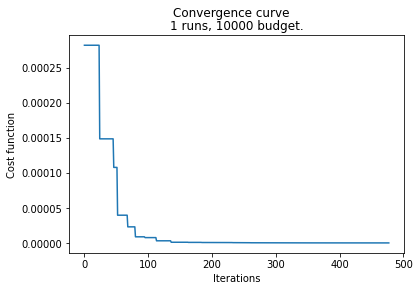

cost: 3.189272857715168e-08
Best guess found:
thicknesses: [111.11685729  75.03256788 100.09412789  75.02028567  99.8709512
  75.04962759  99.88410685  75.03223073  99.92587049  75.03605783
  99.88776404  75.192564    99.71562512  75.01868143 100.09463067
  75.05878     99.94192813  75.05859936  99.85645437  74.96682929
 100.14292611  74.97052836  99.94520481  75.11604587  99.83615128
  74.98291241 100.10691048  74.96409735  99.85571909  75.15211857
  99.90023794  75.03732642  99.99112536  75.0130566   99.87950907
  75.03087392  99.97141194  75.11768311  99.83636916  75.04711256
 100.12522779  74.996401    99.86936289  75.01607816 100.02628675
  75.01368664 100.05340768  74.9325488  100.00794473  75.04985693
  99.86206485  75.0682963  100.02066562  74.99971703  99.90795178
  75.06864507  99.8804432   75.00651602 100.05716901  75.01855161
  99.96044656  74.9822362   48.16585896]


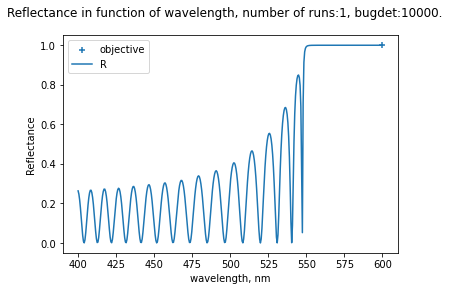

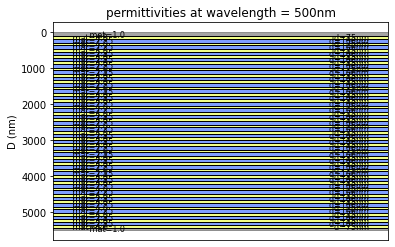

In [8]:
# Créer une instance de la classe 'optimization' qui stock les variables définies plus haut.
optim = optimization(mat, stack, thickness, incidence, polar, X_min, X_max, computation_window, budget, nb_runs, wl_domain, grandeur)

# La méthode 'run()' execute l'algorithme d'optimisation.
# La structure optimisée est stockée dans la variable 'struct'.
struct = optim.run()

# (2/5) Option avancée : Présentation des variables

### optimization.**optimization**(
    mat: list or np.ndarray, 
    stack: list or np.ndarray, 
    thickness: list or np.ndarray, 
    incidence: float, 
    polar: int,
    X_min: np.ndarray, 
    X_max: np.ndarray, 
    computation_window: np.ndarray, 
    budget: int, 
    nb_runs: int, 
    wl_domain: np.ndarray = np.linspace(400, 800, 100), 
    draw_functions = 'R', 
    objective_function = constant, 
    active_layer: float = -1, 
    cost_function = None, 
    which_layers = None, 
    indices: bool = False, 
    optimizer: str = 'QNDE', 
    progression: bool = True, 
    objective_title: str = "comparison curve", 
    objective_ylabel: str = "default", 
    wl_plot_stack: float = 500, 
    precision: int = 3, 
    verbose: bool = False
### )


- mat (list or array of floats or pm.Materials): list of materials*.

- stack (list or array of integers)*

- thickness (list or array of floats)*

- incidence (float): incidence of the light beam above surface (in degree °, 
    between 0° (normal) and 90 ° (tangent) ).

- polar (0 or 1): field polarization. 0 == TE, other is TM.

- X_min (nunmpy ndarray of floats): lower boundaries of the optimization
    domain, a vector with the same size as the argument of the cost function.

- X_max (nunmpy ndarray of floats): upper boundaries, see just above.

- computation_window (nunmpy ndarray of floats): The wavelength
    optimization region. Only for computations.

- budget (integer, default = 1000): number of iteration for optimization.

- nb_runs (integer, default = 1): number of time the optimization is done.

- wl_domain (nunmpy ndarray of floats): The wavelength region to plot.
    Only for plots, and not computations (see below).

- objective_function (function of floats): A function to draw the objective we
    work with. Used to build the 'objective_vector' to compare it to 'draw_function'.

- draw_function (function): function to print and compare to the 'objective_vector'.

ADVANCED PARAMETERS

- active_layer (float) : indicate the active layer in the stack for photovoltaic
    purpose.

- cost_function (function): function to minimize. It requires only
    the argument 'layers'.

- which_layers (nunmpy ndarray of boolean): Same length of 'stack'.
    It indicates which layers are optimized in the stack (which_layer[i] = True).
    Neither the thicknesses nor the optical indices are optimized for the others
    (which_layer[i] = False). 

- indices (boolean): If True, the optical indices are also
    optimized. Optimized layers are indicated by 'which_layers' (see above).
    WARNING : if True, the stack needs to be 'np.arange(len(stack))' to work properly.

- optimizer (string, default = 'DE'): Global Optimization algorithm used.

    Possible choices for the optimizer**:  | name (string)
    ---------------------------------------|--------------
    differential evolution                 | 'DE'
    quasi opposite differential evolution  | 'QODE'
    quasi newtonian differential evolution | 'QNDE'
    bfgs (gradient descent)                | 'BFGS'
    QODE + distance counter                | 'QODEd'
    QNDE + distance counter                | 'QNDEd'
    QODE + bfgs for each individuals in pop| 'super_QNDE'

PRINTING PART

Depending on the number of runs, several plots can show:
If 'nb_runs' = 1, a 'convergence plot' will be shown first. Then a'comparison plot'
will appear between the 'objective_vector' and 'draw_function'. Otherwise, if 'nb_runs' is 
higher than 1, a 'consistency plot' will be shown, which is a superposition of the
'nb_runs' 'consistency' plots. Independently of 'nb_runs' value, a diagram of the
thicknesses and the optical indices will appear.

- progression (boolean, default = False): If True, prints the optimization progression
    as a percentage of computation.

- objective_title (string, default = "comparison plot"): Title for comparison plot
    between the desired objective and the actual optimization.

- objective_ylabel (string, default = "default"): y label for comparisaon plot.

- wl_plot_stack (float, default = 500): wavelength for optical indices for diagram plot.

- precision  (integer, default = 3): printing precision for optical indices.

- verbose (boolean, default = False)

*see 'PyMoosh_Basics.ipynb' tutorial.

**see 'optim_algo.py' for code.

# (3/5) Option avancée : Test de robustesse

**Idée générale** : La fabrication d'une structure multi-couche fait intervenir des incertitudes sur les épaisseurs des couches ainsi construites. Si on considère une structure donnée par l'optimisation précédente, l'efficacité de cette structure varie si une des épaisseurs varie. Par exemple, un mirroir de Bragg perd théoriquement en reflectance dès lors que la première couche change d'épaisseur par rapport à l'épaisseur optimal. Cependant, à quel point la variation des épaisseurs fait perdre en efficacité ? Autrement dit, à quel point la structure est robuste, par rapport au bruit ou aux incertitudes de mesures ?

La méthode `robustness()`  propose un moyen de quantifier cette idée.

**Principe**: à partir d'une structure, l'algorithme cherche la structure donnant la moins efficace dans un périmètre autour de la première. Pour cela on se donne un paramètre d'incertitude, noté `d` (nm) et une structure quelconque. Pour chacune des `i` épaisseurs `th[i]` de cette structure, on construit les bornes `x_min[i]` et `x_max[i]` de l'optimisation en s'éloignant de part de d'autre de l'épaisseur `th[i]` d'une valeur de `d`: pour toutes les `i` couches, `x_min[i] = th[i] - d` et `x_max[i] = th[i] + d`. Les listes `x_min` et `x_max` forment les bornes de la nouvelle 'optimisation'. Pour définir une 'mauvaise' structure, l'algorithm inverse la fonction de coût avant de commencer l'optimisation: `f_cost_worst = 1 - f_cost = Reflectance(structure)`.

En écrivant cette ligne, l'algorithme donne la pire structure et le coût associé pour estimer la perte d'efficacité.

Current Time = 16:11:51
Switching to bfgs gradient descent...
Finished in 3.0 min 15.53 seconds.
cost: 0.999999999999978
Worst guess found:
thicknesses: [119.06743528  84.62200174 100.43784774  66.97568494 102.55036039
  65.18548667  97.19972786  74.97635966  90.09583793  65.30196089
  90.10198756  65.49337541  89.93663348  72.45827514 104.19674411
  66.32940196  93.6687243   65.43487084  93.51815125  65.3753641
  97.83936079  65.40270307  90.27072756  65.54779523  90.14043556
  65.35907484  90.35157303  65.24053351  90.01564965  65.30550452
  89.96709087  65.06978853  91.78053521  68.54630338  94.48135265
  65.0267948   93.85150092  72.71210994  89.83136916  65.04211256
  90.12022779  64.991401    89.86436289  65.01107816  90.02128677
  67.48028461  90.04840769  66.58432919  95.24591108  80.49908293
 105.55269708  70.09926088  93.28278662  64.99471703  93.52858984
  65.06364507  89.8754432   65.00151602 102.56538642  65.01355161
  90.27743922  71.00788126  50.68311303]
List of materia

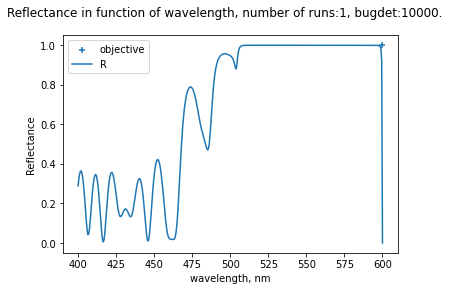

In [18]:
optim.robustness(struct, distance=10.005, budget=100)

Note : les informations intéressantes à comparer sont les coûts de la meilleure structure comparée à la pire en fonction de la distance d'incertitude.

Dans l'exemple ci-dessus, et pour plusieurs distances d'incertitudes, j'obtiens les résultats suivants:


meilleur : 3.1 e-8
d (nm) | pire    |
-------|---------|
2      | 3.3 e-8 |
4      | 3.9 e-8 |
6      | 4.5 e-8 |
8      | 5.8 e-8 |
10     | 7.9 e-8 |
10.05  | 0.99    |



### optimization.optimization.**robustness**(
    structure: PyMoosh.Structure, 
    distance: float,
    budget: int = 5000,
    nb_runs: int = 1
    
### )

# (4/5) Option avancée : Clustering

Idée : l'optimisation globale donne un résultat à partir d'un algorithme non-déterministe. Ce résultat peut changer entre chaque optimisation. Quand on optimise un problème connu, le nombre de solution possible peut être lui aussi connu. En revanche, pour la plupart des problèmes sans solution connue, le nombre de ces solutions et leur forme est encore à déterminer. Comment faire pour estimer ces solutions possibles, et quantifier leur proportions ?

Principe : Un calcul de distance entre chaque structure est faite une fois l'optimisation effectuée. Ces distances peuvent êtres assemblées dans une matrice (symétrique et de diagonale nulle). Un algorithme de parcours sur graphe, appellé DBSCAN, détermine des groupes de structures proches les unes des autres, appelés clusters, le nombre, et d'autres informations pratiques.

In [ ]:
# Créer une instance de la classe 'optimization' qui stock les variables définies plus haut.
optim = optimization(mat, stack, thickness, incidence, polar, X_min, X_max, computation_window, budget, nb_runs, wl_domain, grandeur, optimizer='super_QNDE')

# La structure optimisée est stockée dans la variable 'struct'.
# Les résultats de DBSCAN sont stockés dans 'info'.
struct, info = optim.run()
info = info[0]
print(f'population:{info[0]}')
print(f'cluster_count:{info[1]}')
print(f'noise_count:{info[2]}')
print(f'best_in_cluster_list:{info[3]}')
print(f'cost_best_list:{info[4]}')
print(f'density_list:{info[5]}')

Attention : une descente de gradient est effectuée pour chaque individus (30 par défaut). Cela peut prendre beaucoup plus de temps que QODE ou QNDE.

L'algorithme DBSCAN fait intervenir la notion de rayon de cluster, distance maximal entre deux structures pour êtres considérées dans le même cluster. Comme il y a $n$ couches, chaque structure est un vecteur dans un espace de dimension $n$. En dimension 2, il est facile de se représenter cette surface autorisée en représentant un cercle centré autour de notre structure et de même rayon. En dimension $n$, l'espace autorisé est de dimension $n-1$, moins évident à se représenter. Pour pallier à ce problème, on peut faire le raisonnement suivant : si je m'éloigne de ma structure d'un pas de $d$ pour chaque couche, telle que la distance à la structure vaut le rayon de cluster, on a :

$rayon \ de \ cluster = \sqrt{\sum_{i=1}^{n} d^{2}} = \sqrt{n \times d^{2}} = \sqrt n \times d $

On peut alors parler de $d$, un paramètre invariant par rapport au nombre de couches (contrairement au rayon de cluster).
Par exemple, pour $d = 10 nm$ le rayon de cluster vaut $r = 54.7 nm$ pour une structure à 30 couches, et vaut $r=70.7 nm$ pour une structure à 50 couches.

# (5/5) Commentaires diverses

### Limites du code :

- temps d'execution : même si certaines fonctions ont été "paraléllisées" pour accélérer les calculs, la descente de gradient est l'algorithme qui prend le plus de temps à l'execution (je n'ai pas optimisié bfgs). C'est d'autant plus limitant pour 'super_QNDE' qui fait une descente de gradient pour chaque individu (omega) de DE.
- paramètre des clusters (voir doc DBSCAN) : n'apparaissent pas à l'utilisateur pour l'instant (nombre d'individus par cluster, rayon de cluster, paramètre d...)

### Questionnements :

- 'cut_budget' dans QNDE, super_QNDE : le paramètre n'est pas visible par l'utilisateur s'il utilise seulement 'optimization'. Je n'ai pas fait un QNDE moitié DE moitié gradient car la partie gradient prenait beaucoup trop de temps à se faire.
- Clustering : les informations renvoyées par cette méthode sont elles assez lisibles et compréhensibles ?

### Ouvertures :

- Essayer d'optimiser la descente de gradient ?
- Clustering : donner des indicateurs de confiance en la réponse de l'algo DBSCAN (voir doc DBSCAN)
- Clustering : ajouter une méthode qui donne le nombre et la densité des clusters (partition de la population) en fonction de la taille décreissante des clusters. Ces informations pourraient être représentées sur un arbre (graphe) avec les noeuds représentants les densités de chaque cluster, et les flèches l'inclusion de ce cluster dans un cluster plus grand.
Ces informations pourraient (?) être utile pour connaître la fréquence d'apparition des solutions par l'algorithme d'optimisation pour un problème donné.